# OPEN CV Line Detection

https://docs.opencv.org/3.4/d9/db0/tutorial_hough_lines.html

In [4]:
# system
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../')))

from config.path import get_training_data_path, get_all_files_from_folder

import cv2
import numpy as np
import matplotlib.pyplot as plt

In [55]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random 
def correct_rotation_and_display_with_lines(image):
    # Load image
    image = cv2.medianBlur(image, 11)


    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB for displaying
    #image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Convert to grayscale and equalize histogram


    gray = cv2.equalizeHist(gray)

    # Detect edges
    edges = cv2.Canny(gray, 10, 100, apertureSize=5)
    
    # Use Hough Line Transform to detect lines
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=100, minLineLength=200, maxLineGap=50)

    if lines is not None:
        # Prepare to calculate the average angle
        sin_sum = 0
        cos_sum = 0

        for line in lines:
            x1, y1, x2, y2 = line[0]
            length = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
            #print(length)
            if length > 200:
                cv2.line(image, (x1, y1), (x2, y2), (255, 0, 0), 3)  # Draw each detected line in red
                cv2.circle(image, (x1, y1), 3, (0, 255, 0)) 
                cv2.circle(image, (x2, y2), 3, (0, 255, 0)) 
                angle = np.arctan2(y2 - y1, x2 - x1)
                sin_sum += np.sin(angle)
                cos_sum += np.cos(angle)

        # Calculate average angle using vector sums
        average_angle = np.arctan2(sin_sum, cos_sum)
        average_angle_degrees = np.degrees(average_angle)

        #print("Average Angle: ", average_angle_degrees)

        # Rotate image to align
        width, height = image.shape[1], image.shape[0]
        rotation_matrix = cv2.getRotationMatrix2D((width // 2, height // 2), -40, 1)
        rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height))
        return average_angle_degrees
    else:
        rotated_image = image  # No rotation if no lines are detected
        return 0


    # # Display the original and rotated images using matplotlib
    # plt.figure(figsize=(12, 6))
    # plt.subplot(121)
    # plt.imshow(image)
    # plt.title('Image with Lines')
    # plt.axis('off')

    # plt.subplot(122)
    # plt.imshow(rotated_image)
    # plt.title('Rotated Image')
    # plt.axis('off')

    # plt.show()




In [38]:
path = get_training_data_path(data_type='classifier', class_type='tshirt')
files = get_all_files_from_folder(path)
files = files[:30]
len(files)

30

In [36]:
def rotate_image(image_path, angle):
    # Load the image
    image = cv2.imread(image_path)
    
    if image is None:
        raise ValueError("Image not found or path is incorrect.")
    
    # Get the dimensions of the image
    (height, width) = image.shape[:2]
    
    # Compute the center of the image
    center = (width // 2, height // 2)
    
    # Get the rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    
    # Compute the new dimensions of the image
    # This ensures the rotated image fits in the frame
    abs_cos = abs(rotation_matrix[0, 0])
    abs_sin = abs(rotation_matrix[0, 1])
    
    # Compute new bounding dimensions
    new_width = int(height * abs_sin + width * abs_cos)
    new_height = int(height * abs_cos + width * abs_sin)
    
    # Adjust the rotation matrix to take into account the translation
    rotation_matrix[0, 2] += (new_width / 2) - center[0]
    rotation_matrix[1, 2] += (new_height / 2) - center[1]
    
    # Rotate the image
    rotated_image = cv2.warpAffine(image, rotation_matrix, (new_width, new_height))
    
    return rotated_image


Mean Absolute Error: 83.77°
Standard Deviation of Error: 66.14°


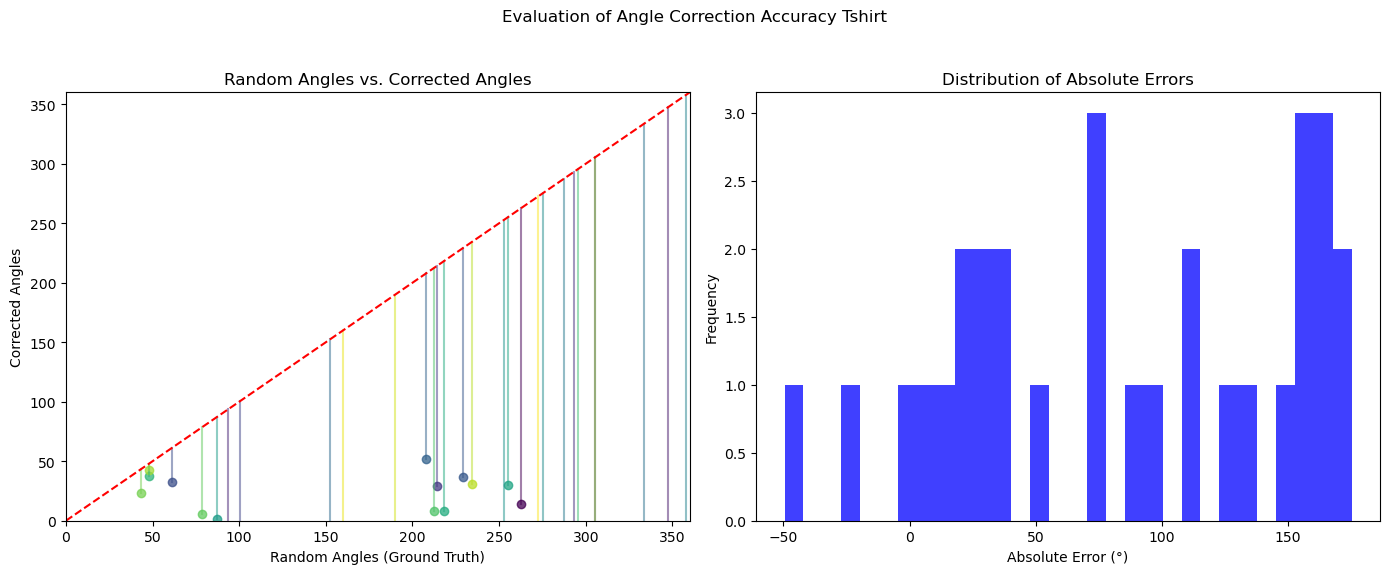

In [60]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np

# Assuming rotate_image and find_contours_and_extreme_points are already defined

res = []

for file in files:
    fullpath = os.path.join(path, file)
    random_angle = random.uniform(0, 360)
    img = rotate_image(fullpath, random_angle)
    corrected_angle = correct_rotation_and_display_with_lines(img)
    res.append([random_angle, corrected_angle])

# Convert to numpy array for easier manipulation
res = np.array(res)
random_angles = res[:, 0]
corrected_angles = res[:, 1]

# Compute absolute errors
errors = np.abs(random_angles - corrected_angles)
errors = np.minimum(errors, 360 - errors)  # Account for circular nature of angles

# Calculate summary statistics
mean_error = np.mean(errors)
std_error = np.std(errors)

# Print summary statistics
print(f'Mean Absolute Error: {mean_error:.2f}°')
print(f'Standard Deviation of Error: {std_error:.2f}°')

# Assign unique colors to each pair
colors = plt.cm.viridis(np.linspace(0, 1, len(random_angles)))

# Visualization
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Scatter plot of random angles vs. corrected angles with pair-wise colors and lines
for i in range(len(random_angles)):
    ax[0].scatter(random_angles[i], corrected_angles[i], color=colors[i], alpha=0.75)
    ax[0].plot([random_angles[i], random_angles[i]], [random_angles[i], corrected_angles[i]], color=colors[i], alpha=0.5, linestyle='-')

ax[0].plot([0, 360], [0, 360], color='red', linestyle='--')  # Perfect correlation line
ax[0].set_xlabel('Random Angles (Ground Truth)')
ax[0].set_ylabel('Corrected Angles')
ax[0].set_title('Random Angles vs. Corrected Angles')
ax[0].set_xlim([0, 360])
ax[0].set_ylim([0, 360])

# Histogram of errors
ax[1].hist(errors, bins=30, alpha=0.75, color='blue')
ax[1].set_xlabel('Absolute Error (°)')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Distribution of Absolute Errors')

plt.suptitle('Evaluation of Angle Correction Accuracy Tshirt')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
